In [3]:
import polars as pl

# Data processing

In [82]:
ctd_chg = pl.scan_csv(
    './data/raw/CTD_chem_gene_ixns.tsv',
    separator = '\t',
    schema_overrides = pl.Schema({
      'ChemicalName': pl.String,
      'ChemicalID': pl.String,
      'GeneID': pl.Int64,
      'InteractionActions': pl.String
    })
).select(['ChemicalName', 'ChemicalID', 'GeneID', 'InteractionActions']).rename({
    'ChemicalName': 'CHEM_NAME',
    'ChemicalID': 'CHEM_MESH_ID',
    'GeneID': 'GENE_NCBI_ID',
    'InteractionActions': 'INTERACTIONS'
})
ctd_chd = pl.scan_csv(
    './data/raw/CTD_curated_chemicals_diseases.tsv',
    separator = '\t',
    schema_overrides = pl.Schema({
      'ChemicalName': pl.String,
      'ChemicalID': pl.String,
      'DiseaseName': pl.String,
      'DiseaseID': pl.String
    })
).select(['ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID']).rename({
    'ChemicalName': 'CHEM_NAME',
    'ChemicalID': 'CHEM_MESH_ID',
    'DiseaseName': 'DS_NAME',
    'DiseaseID': 'DS_OMIM_MESH_ID'
})
ctd_dg = pl.scan_csv(
    './data/raw/CTD_curated_genes_diseases.tsv',
    separator = '\t',
    schema_overrides = pl.Schema({
      'GeneID': pl.Int64,
      'DiseaseName': pl.String,
      'DiseaseID': pl.String,
      'OmimIDs': pl.String
    })
).select(['GeneID', 'DiseaseName', 'DiseaseID', 'OmimIDs']).rename({
    'GeneID': 'GENE_NCBI_ID',
    'DiseaseName': 'DS_NAME',
    'DiseaseID': 'DS_OMIM_MESH_ID',
    'OmimIDs': 'DS_OMIM_IDS'
})
ppi = pl.scan_csv(
    './data/raw/PP-Decagon_ppi.csv',
    has_header = False,
    new_columns = [
        'GENE_NCBI_ID_1',
        'GENE_NCBI_ID_2'
    ]
)

ctd_chd:
  - Disease ID - MESH/OMIM
  - Chem ID - MESH
  
ctd_chg:
  - Chem ID - MESH
  - Gene ID - NCBI
  
ctd_dg:
  - Disease ID - MESH/OMIM
  - Gene ID - NCBI
  
ppi:
  - Both are NCBI

In [83]:
genes_core = (
  ctd_chg.select(pl.col('GENE_NCBI_ID').unique())
  .join(
    ctd_dg.select(pl.col('GENE_NCBI_ID').unique()),
    on = 'GENE_NCBI_ID',
    how = 'inner'
    )
  .join(
    pl.concat([
      ppi.select('GENE_NCBI_ID_1').rename({'GENE_NCBI_ID_1': 'GENE_NCBI_ID'}),
      ppi.select('GENE_NCBI_ID_2').rename({'GENE_NCBI_ID_2': 'GENE_NCBI_ID'})
    ],
      how = 'vertical'
    ).unique(),
    on = 'GENE_NCBI_ID',
    how = 'inner'
  )
  .with_columns(
    pl.col('GENE_NCBI_ID').cast(pl.UInt32)
  )
).with_row_index('GENE_ID').collect()
ds_core = (
  ctd_dg.select(['DS_OMIM_MESH_ID', 'DS_NAME']).unique('DS_OMIM_MESH_ID')
  .join(
    ctd_chd.select(['DS_OMIM_MESH_ID', 'DS_NAME']).unique('DS_OMIM_MESH_ID'),
    on = 'DS_OMIM_MESH_ID',
    how = 'inner'
    )
).select(pl.col('DS_OMIM_MESH_ID', 'DS_NAME')).with_row_index('DS_ID').collect()
chems_core = (
  ctd_chg.select(['CHEM_MESH_ID', 'CHEM_NAME']).unique('CHEM_MESH_ID')
  .join(
    ctd_chd.select(['CHEM_MESH_ID', 'CHEM_NAME']).unique('CHEM_MESH_ID'),
    on = 'CHEM_MESH_ID',
    how = 'inner'
    )
).select(pl.col('CHEM_MESH_ID', 'CHEM_NAME')).with_row_index('CHEM_ID').collect()

In [84]:
r = []
for i in [genes_core, ds_core, chems_core]:
  r.append(i.height)
print(f'Genes: {r[0]}\nDiseases: {r[1]}\nChemicals: {r[2]}\n\nAll nodes: {sum(r)}')

Genes: 8095
Diseases: 1885
Chemicals: 7906

All nodes: 17886


In [85]:
ctd_chg_final = (
  ctd_chg.collect()
  .join(genes_core, on='GENE_NCBI_ID', how='inner')
  .join(chems_core, on='CHEM_MESH_ID', how='inner')
  .with_columns([
    pl.col('INTERACTIONS').cast(pl.Utf8).fill_null('').alias('INTERACTIONS'),
    pl.col('INTERACTIONS').str.contains(r'\|').alias('has_list'),
    pl.col('INTERACTIONS').str.count_matches(r'\|').alias('n_pipes'),
    pl.col('INTERACTIONS').str.len_chars().alias('n_chars'),
  ])
  .group_by(['CHEM_MESH_ID', 'GENE_NCBI_ID'])
  .agg([
    pl.col('INTERACTIONS')
      .sort_by(['has_list', 'n_pipes', 'n_chars'], descending=True)
      .first()
      .alias('INTERACTIONS'),
    pl.first('CHEM_ID').alias('CHEM_ID'),
    pl.first('GENE_ID').alias('GENE_ID'),
  ])
  .with_columns(
    pl.when(pl.col('INTERACTIONS') == '')
      .then(pl.lit(None, dtype=pl.List(pl.Utf8)))
      .otherwise(pl.col('INTERACTIONS').str.split('|'))
      .alias('INTERACTION_ITEM')
  )
  .explode('INTERACTION_ITEM')
  .drop_nulls('INTERACTION_ITEM')
  .with_columns(
    pl.col('INTERACTION_ITEM')
      .str.split_exact('^', 1)
      .struct.rename_fields(['ACTION_TYPE', 'ACTION_SUBJECT'])
      .alias('parts')
  )
  .unnest('parts')
  .select([
    'CHEM_ID',
    'GENE_ID',
    'ACTION_TYPE',
    'ACTION_SUBJECT',
  ])
  .unique()
  .with_row_index('CHEM_GENE_IDX')
)
ctd_dg_final = (
  ctd_dg.collect()
  .join(genes_core, on = 'GENE_NCBI_ID')
  .join(ds_core, on = 'DS_OMIM_MESH_ID')
  .unique(['GENE_NCBI_ID', 'DS_OMIM_MESH_ID'])
  .select([
    'GENE_ID',
    'DS_ID'
  ])
  .with_row_index('GENE_DS_IDX')
)
ctd_chd_final = (
  ctd_chd.collect()
  .join(chems_core, on = 'CHEM_MESH_ID')
  .join(ds_core, on = 'DS_OMIM_MESH_ID')
  .unique(['CHEM_MESH_ID', 'DS_OMIM_MESH_ID'])
  .select([
    'CHEM_ID',
    'DS_ID'
  ])
  .with_row_index('CHEM_DS_IDX')
)
ppi_final = (
  ppi.collect()
  .join(
    genes_core.select([
      pl.col('GENE_NCBI_ID').alias('GENE_NCBI_ID_1'),
      pl.col('GENE_ID').alias('GENE_ID_1'),
    ]),
    on='GENE_NCBI_ID_1',
    how='inner',
  )
  .join(
    genes_core.select([
      pl.col('GENE_NCBI_ID').alias('GENE_NCBI_ID_2'),
      pl.col('GENE_ID').alias('GENE_ID_2'),
    ]),
    on='GENE_NCBI_ID_2',
    how='inner',
  )
  .filter(pl.col('GENE_ID_1') != pl.col('GENE_ID_2'))
  .with_columns([
    pl.min_horizontal('GENE_ID_1', 'GENE_ID_2').alias('GENE_ID_1'),
    pl.max_horizontal('GENE_ID_1', 'GENE_ID_2').alias('GENE_ID_2'),
  ])
  .select(['GENE_ID_1', 'GENE_ID_2'])
  .unique()
  .with_row_index('PPI_IDX')
)
ppi_directed = pl.concat([
  ppi_final.select([
    pl.col('GENE_ID_1').alias('GENE_ID_1'),
    pl.col('GENE_ID_2').alias('GENE_ID_2'),
  ]),
  ppi_final.select([
    pl.col('GENE_ID_2').alias('GENE_ID_1'),
    pl.col('GENE_ID_1').alias('GENE_ID_2'),
  ]),
], how='vertical').with_row_index('PPI_DIR_IDX')


In [86]:
print(f'Chemical-Gene edges: {ctd_chg_final.height}')
print(f'Disease-Gene edges: {ctd_dg_final.height}')      
print(f'Chemical-Disease edges: {ctd_chd_final.height}')
print(f'PPI edges: {ppi_final.height}')
print(f'PPI directed edges: {ppi_directed.height}')
print(f'All edges (PPI undirected): {ctd_chg_final.height + ctd_dg_final.height + ctd_chd_final.height + ppi_final.height}')
print(f'All edges (PPI directed): {ctd_chg_final.height + ctd_dg_final.height + ctd_chd_final.height + ppi_directed.height}')

Chemical-Gene edges: 1327372
Disease-Gene edges: 27182
Chemical-Disease edges: 87959
PPI edges: 264560
PPI directed edges: 529120
All edges (PPI undirected): 1707073
All edges (PPI directed): 1971633


In [87]:
# nodes
genes_core.write_parquet('./data/processed/genes_nodes.parquet')
ds_core.write_parquet('./data/processed/diseases_nodes.parquet')
chems_core.write_parquet('./data/processed/chemicals_nodes.parquet')

# edges
ctd_chg_final.write_parquet('./data/processed/chem_gene_edges.parquet')
ctd_dg_final.write_parquet('./data/processed/disease_gene_edges.parquet')
ctd_chd_final.write_parquet('./data/processed/chem_disease_edges.parquet')
ppi_final.write_parquet('./data/processed/ppi_edges.parquet')
ppi_directed.write_parquet('./data/processed/ppi_directed_edges.parquet')

In [88]:
del genes_core,ds_core, chems_core
del ctd_chd_final, ctd_dg_final, ctd_chg_final
del ppi_final, ppi_directed, ctd_chd, ctd_dg, ctd_chg, ppi

# Modelling

In [4]:
# nodes
gnodes = pl.read_parquet('./data/processed/genes_nodes.parquet')
dnodes = pl.read_parquet('./data/processed/diseases_nodes.parquet')
cnodes = pl.read_parquet('./data/processed/chemicals_nodes.parquet')

# edges
cd = pl.read_parquet('./data/processed/chem_disease_edges.parquet')
cg = pl.read_parquet('./data/processed/chem_gene_edges.parquet')
dg = pl.read_parquet('./data/processed/disease_gene_edges.parquet')
ppi = pl.read_parquet('./data/processed/ppi_edges.parquet')
ppi_directed = pl.read_parquet('./data/processed/ppi_directed_edges.parquet')

In [5]:
for name, df in [
  ('chemical-disease', cd),
  ('chemical-gene', cg),
  ('disease-gene', dg),
  ('ppi', ppi),
  ('ppi_directed', ppi_directed),
  ('gene-nodes', gnodes),
  ('disease-nodes', dnodes),
  ('chemical-nodes', cnodes),
]:
  print(f'\n{name}')
  print(df.head(5))



chemical-disease
shape: (5, 3)
┌─────────────┬─────────┬───────┐
│ CHEM_DS_IDX ┆ CHEM_ID ┆ DS_ID │
│ ---         ┆ ---     ┆ ---   │
│ u32         ┆ u32     ┆ u32   │
╞═════════════╪═════════╪═══════╡
│ 0           ┆ 6956    ┆ 1435  │
│ 1           ┆ 4580    ┆ 1427  │
│ 2           ┆ 5325    ┆ 151   │
│ 3           ┆ 6799    ┆ 293   │
│ 4           ┆ 5114    ┆ 742   │
└─────────────┴─────────┴───────┘

chemical-gene
shape: (5, 5)
┌───────────────┬─────────┬─────────┬─────────────┬────────────────┐
│ CHEM_GENE_IDX ┆ CHEM_ID ┆ GENE_ID ┆ ACTION_TYPE ┆ ACTION_SUBJECT │
│ ---           ┆ ---     ┆ ---     ┆ ---         ┆ ---            │
│ u32           ┆ u32     ┆ u32     ┆ str         ┆ str            │
╞═══════════════╪═════════╪═════════╪═════════════╪════════════════╡
│ 0             ┆ 2866    ┆ 6917    ┆ decreases   ┆ reaction       │
│ 1             ┆ 550     ┆ 3943    ┆ decreases   ┆ expression     │
│ 2             ┆ 1518    ┆ 2850    ┆ affects     ┆ cotreatment    │
│ 3          

# Graph Construction

In [6]:
from torch_geometric.data import HeteroData
import torch
import numpy as np
from typing import Dict, Tuple

In [7]:
def _assert_correct_ids(
    nodes: pl.DataFrame,
    id_col: str
) -> int:
  """
    Ensures:
      - IDs are unique
      - min == 0
      - max == n-1
      - all ints
    Returns n (=num_nodes).
  """
  s = nodes.select(pl.col(id_col)).to_series()

  if not s.dtype.is_unsigned_integer():
    raise TypeError(f'ID column {id_col} must be of integer type, got {s.dtype}.')
  
  n = nodes.height
  if n == 0:
    raise ValueError(f'Node DataFrame for {id_col} is empty.')
  
  min_id = s.min()
  max_id = s.max()
  n_unique = s.n_unique()

  if n_unique != n:
    raise ValueError(f'ID column {id_col} must have unique values, got {n_unique} unique values for {n} rows.')
  if min_id != 0:
    raise ValueError(f'ID column {id_col} must have minimum value 0, got {min_id}.')
  if max_id != n - 1:
    raise ValueError(f'ID column {id_col} must have maximum value {n - 1}, got {max_id}.')
  

  present = np.zeros(n, dtype = np.bool_)
  present[np.asarray(s.to_numpy(), dtype = np.int64)] = True
  if not present.all():
    missing = np.where(~present)[0][:10]
    raise ValueError(f'ID column {id_col} is missing values: {missing}...')
  
  return n

In [8]:
def _cat_ids_from_col(
    df: pl.DataFrame,
    col: str
) -> Tuple[pl.DataFrame, pl.DataFrame]:
  """
    Create integer IDs for a categorical string column.
    Returns:
      - df_with_id: original df + {col}_ID (u32) - col
      - vocab_df: mapping {col}_ID, {col}
  """
  vocab = (
    df.select(col)
    .unique()
    .sort(col)
    .with_row_index(f'{col}_ID')
  )
  
  df = df.join(
    vocab,
    on = col,
    how = 'left'
  ).drop(col)

  return df, vocab.select([f'{col}_ID', col])

In [9]:
def build_hetero_data(
  *,
  cnodes: pl.DataFrame,
  dnodes: pl.DataFrame,
  gnodes: pl.DataFrame,
  cd: pl.DataFrame,
  cg: pl.DataFrame,
  dg: pl.DataFrame,
  ppi: pl.DataFrame,
  add_reverse_edges: bool = True,
) -> Tuple[HeteroData, Dict[str, pl.DataFrame]]:
  num_chem = _assert_correct_ids(cnodes, 'CHEM_ID')
  num_ds = _assert_correct_ids(dnodes, 'DS_ID')
  num_gene = _assert_correct_ids(gnodes, 'GENE_ID')

  cg, action_type_vocab = _cat_ids_from_col(cg, 'ACTION_TYPE')
  cg, action_subject_vocab = _cat_ids_from_col(cg, 'ACTION_SUBJECT')
  vocabs = {
    'action_type': action_type_vocab,
    'action_subject': action_subject_vocab
  }

  data = HeteroData()
  # nodes
  data['chemical'].num_nodes = num_chem
  data['disease'].num_nodes = num_ds
  data['gene'].num_nodes = num_gene

  data['chemical'].x = torch.arange(num_chem).view(-1, 1)
  data['disease'].x = torch.arange(num_ds).view(-1, 1)
  data['gene'].x = torch.arange(num_gene).view(-1, 1)

  # edges
  data['chemical', 'associated_with', 'disease'].edge_index = torch.from_numpy(
    cd.select(['CHEM_ID', 'DS_ID']).to_numpy().T.astype(np.int64)
  ).long()

  data['chemical', 'affects', 'gene'].edge_index = torch.from_numpy(
    cg.select(['CHEM_ID', 'GENE_ID']).to_numpy().T.astype(np.int64)
  ).long()

  data['disease', 'targets', 'gene'].edge_index = torch.from_numpy(
    dg.select(['DS_ID', 'GENE_ID']).to_numpy().T.astype(np.int64)
  ).long()

  data['gene', 'interacts_with', 'gene'].edge_index = torch.from_numpy(
    ppi.select(['GENE_ID_1', 'GENE_ID_2']).to_numpy().T.astype(np.int64)
  ).long()

  # edge attributes for chemical-gene (ACTION_TYPE_ID, ACTION_SUBJECT_ID)
  cg_edge_attr = torch.from_numpy(
    cg.select(['ACTION_TYPE_ID', 'ACTION_SUBJECT_ID']).to_numpy().astype(np.int64)
  ).long()
  data['chemical', 'affects', 'gene'].edge_attr = cg_edge_attr

  if add_reverse_edges:
    data['disease', 'rev_associated_with', 'chemical'].edge_index = torch.flip(
      data['chemical', 'associated_with', 'disease'].edge_index, dims=[0]
    )

    data['gene', 'rev_affects', 'chemical'].edge_index = torch.flip(
      data['chemical', 'affects', 'gene'].edge_index, dims=[0]
    )
    # Copy edge attrs to reverse edges (same attributes apply)
    data['gene', 'rev_affects', 'chemical'].edge_attr = cg_edge_attr.clone()
    
    data['gene', 'rev_targets', 'disease'].edge_index = torch.flip(
      data['disease', 'targets', 'gene'].edge_index, dims=[0]
    )

    # Add reverse edges for PPI to make it bidirectional for message passing
    data['gene', 'rev_interacts_with', 'gene'].edge_index = torch.flip(
      data['gene', 'interacts_with', 'gene'].edge_index, dims=[0]
    )

  data.validate(raise_on_error=True)

  return data, vocabs


In [10]:
# NOTE: Use undirected ppi edges. The PPI network is inherently undirected,
# and using ppi_directed doubles edges unnecessarily. For message passing
# symmetry, we add reverse edges within build_hetero_data for other relations.
data, vocabs = build_hetero_data(
  cnodes=cnodes,
  dnodes=dnodes,
  gnodes=gnodes,
  cd=cd,
  cg=cg,
  dg=dg,
  ppi=ppi,  # Use undirected PPI edges
  add_reverse_edges=True
)

In [11]:
for n in vocabs.items():
  n[1].write_csv(f'./data/processed/vocab_{n[0]}.csv')

# Splits

In [12]:
from dataclasses import dataclass
from typing import Optional
from torch.utils.data import DataLoader, Dataset
from torch_geometric.loader import LinkNeighborLoader

In [13]:
@dataclass
class LinkSplit:
  train_pos: torch.Tensor # [2, E_train]
  val_pos: torch.Tensor   # [2, E_val]
  test_pos: torch.Tensor  # [2, E_test]

In [14]:
def split_cd(
    cd_idx: torch.Tensor,
    val_ratio: float = 0.1,
    test_ratio: float = 0.1,
    seed: int = 42
) -> LinkSplit:
  assert cd_idx.dtype == torch.long
  assert cd_idx.dim() == 2 and cd_idx.size(0) == 2
  E = cd_idx.size(1)

  n_test = int(E * test_ratio)
  n_val = int(E * val_ratio)
  n_train = E - n_val - n_test
  assert n_train > 0 and n_val > 0 and n_test > 0, "Not enough edges to split."

  g = torch.Generator()
  g.manual_seed(seed)
  perm = torch.randperm(E, generator = g)

  train_idx = perm[:n_train]
  val_idx = perm[n_train:n_train + n_val]
  test_idx = perm[n_train + n_val:]

  return LinkSplit(
    train_pos = cd_idx[:, train_idx].contiguous(),
    val_pos = cd_idx[:, val_idx].contiguous(),
    test_pos = cd_idx[:, test_idx].contiguous(),
  )

In [15]:
split = split_cd(
  data[('chemical', 'associated_with', 'disease')].edge_index
)

In [16]:
def make_split_graph(
    data: HeteroData,
    train_cd_idx: torch.Tensor,
    cd_rel: Tuple[str, str, str] = ('chemical', 'associated_with', 'disease'),
    cd_rev_rel: Tuple[str, str, str] = ('disease', 'rev_associated_with', 'chemical')
) -> HeteroData:
  dat = data.clone()
  dat[cd_rel].edge_index = train_cd_idx
  if cd_rev_rel in dat.edge_types:
    dat[cd_rev_rel].edge_index = torch.flip(train_cd_idx, dims = [0])
  dat.validate()
  return dat

In [17]:
class PackedPairFilter:
  """
    Membership test for (chem, dis) pairs using packed int64 keys:
      key = chem * num_dis + dis

    Store all known positives (train+val+test, and optionally external positives).
  """

  def __init__(
      self,
      pos_idx: torch.Tensor,
      num_dis: int
    ):
    assert pos_idx.dtype == torch.long and pos_idx.size(0) == 2
    self.num_dis = int(num_dis)

    chem = pos_idx[0].to(torch.int64)
    dis = pos_idx[1].to(torch.int64)
    keys = (chem * self.num_dis + dis).tolist()
    self._set = set(keys)

  def contains_mask_cpu(
      self,
      chem: torch.Tensor,
      dis: torch.Tensor
  ) -> torch.Tensor:
    """
      Returns bool mask on CPU: True where (chem, dis) is a known positive.
    """
    chem = chem.to(torch.int64).cpu()
    dis = dis.to(torch.int64).cpu()
    keys = (chem * self.num_dis + dis).tolist()
    return torch.tensor([k in self._set for k in keys], dtype = torch.bool)

In [18]:
@torch.no_grad()
def negative_sample_cd_batch_local(
  batch_data: HeteroData,
  pos_edge_index_local: torch.Tensor, # [2, B] local indicies
  known_pos: PackedPairFilter, # global positives filter
  num_neg_per_pos: int = 5,
  max_tries: int = 20
):
  """
    Generate negative samples for chemical-disease link prediction.
    
    For each positive (chem, disease) pair, creates num_neg_per_pos negatives
    by corrupting either the chemical OR the disease (not both initially).
    
    On collision (if randomly generated pair is a known positive), 
    maintains the same corruption strategy for consistency.
  """
  device = pos_edge_index_local.device
  B = pos_edge_index_local.size(1)
  N = B * num_neg_per_pos

  nchem = batch_data['chemical'].num_nodes
  ndis = batch_data['disease'].num_nodes

  # Map local to global IDs for collision checking
  chem_gid = batch_data['chemical'].x.view(-1).long()
  dis_gid = batch_data['disease'].x.view(-1).long()

  # Start from positive pairs
  chem_l = pos_edge_index_local[0].repeat_interleave(num_neg_per_pos).clone()
  dis_l = pos_edge_index_local[1].repeat_interleave(num_neg_per_pos).clone()

  # Decide corruption strategy: True = corrupt disease, False = corrupt chemical
  corrupt_disease = torch.rand(N, device=device) < 0.5
  
  # Apply initial corruption
  nd = int(corrupt_disease.sum().item())
  if nd > 0:
    dis_l[corrupt_disease] = torch.randint(0, ndis, (nd,), device=device)
  nc = N - nd
  if nc > 0:
    chem_l[~corrupt_disease] = torch.randint(0, nchem, (nc,), device=device)

  # Handle collisions while maintaining corruption strategy
  for _ in range(max_tries):
    chem_g = chem_gid[chem_l].cpu()
    dis_g = dis_gid[dis_l].cpu()
    coll = known_pos.contains_mask_cpu(chem_g, dis_g).to(device)
    if not bool(coll.any()):
      break
    
    # Re-sample collisions using SAME corruption strategy
    coll_corrupt_dis = coll & corrupt_disease
    coll_corrupt_chem = coll & (~corrupt_disease)
    
    nd_coll = int(coll_corrupt_dis.sum().item())
    nc_coll = int(coll_corrupt_chem.sum().item())
    
    if nd_coll > 0:
      dis_l[coll_corrupt_dis] = torch.randint(0, ndis, (nd_coll,), device=device)
    if nc_coll > 0:
      chem_l[coll_corrupt_chem] = torch.randint(0, nchem, (nc_coll,), device=device)

  return torch.stack([chem_l, dis_l], dim=0).long()


In [19]:
def make_link_loaders(
  data: HeteroData,
  split: LinkSplit,
  batch_size: int = 1024,
  num_neighbours = [10, 5] 
):
  cd_etype = ('chemical', 'associated_with', 'disease')

  train_loader = LinkNeighborLoader(
    data = data,
    num_neighbors = num_neighbours,
    edge_label_index = (cd_etype, split.train_pos),
    edge_label = torch.ones(split.train_pos.size(1)),
    neg_sampling_ratio = 0,
    batch_size = batch_size,
    shuffle = True
  )

  test_loader = LinkNeighborLoader(
    data = data,
    num_neighbors = num_neighbours,
    edge_label_index = (cd_etype, split.test_pos),
    edge_label = torch.ones(split.test_pos.size(1)),
    neg_sampling_ratio = 0,
    batch_size = batch_size,
    shuffle = False
  )

  val_loader = LinkNeighborLoader(
    data = data,
    num_neighbors = num_neighbours,
    edge_label_index = (cd_etype, split.val_pos),
    edge_label = torch.ones(split.val_pos.size(1)),
    neg_sampling_ratio = 0,
    batch_size = batch_size,
    shuffle = False
  )

  return train_loader, val_loader, test_loader

In [20]:
@dataclass
class SplitArtifacts:
  data_train: HeteroData
  split: LinkSplit
  known_pos: PackedPairFilter
  train_loader: DataLoader
  val_loader: DataLoader
  test_loader: DataLoader

In [21]:
def prepare_splits_and_loaders(
  data_full: HeteroData,
  cd_rel: Tuple[str, str, str] = ('chemical', 'associated_with', 'disease'),
  rev_cd_rel: Tuple[str, str, str] = ('disease', 'rev_associated_with', 'chemical'),
  val_ratio: float = 0.1,
  test_ratio: float = 0.1,
  seed: int = 42,
  batch_size: int = 4096
) -> SplitArtifacts:
  # split positives for CD
  cd_all = data_full[cd_rel].edge_index
  split = split_cd(
    cd_all,
    val_ratio = val_ratio,
    test_ratio = test_ratio,
    seed = seed
  )

  # make training graph
  data_train = make_split_graph(
    data_full,
    split.train_pos,
    cd_rel = cd_rel,
    cd_rev_rel = rev_cd_rel
  )

  # prepare known positives filter
  pos_all = torch.cat([split.test_pos, split.val_pos, split.train_pos], dim = 1)
  num_dis = data_full['disease'].num_nodes
  known_pos = PackedPairFilter(
    pos_all.cpu(),
    num_dis
  )

  # loaders
  train_loader, val_loader, test_loader = make_link_loaders(
    data = data_train,
    split = split,
    batch_size = batch_size,
    num_neighbours = [10, 5]
  )

  return SplitArtifacts(
    data_train = data_train,
    split = split,
    known_pos = known_pos,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader
  )

In [22]:
arts = prepare_splits_and_loaders(
  data_full = data,
  cd_rel = ('chemical', 'associated_with', 'disease'),
  rev_cd_rel = ('disease', 'rev_associated_with', 'chemical'),
  val_ratio = 0.1,
  test_ratio = 0.1,
  seed = 42,
  batch_size = 4096
)

# Modelling

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn

In [24]:
class EdgeAttrHeteroConv(nn.Module):
  """
    Heterogeneous Graph Convolution with edge attribute support.
    
    For edge types with attributes (chemical->gene), uses edge embeddings
    to modulate message passing. For other edge types, uses standard linear transform.
  """
  def __init__(
      self,
      in_channels: int,
      out_channels: int,
      metadata,
      num_action_types: int = 0,
      num_action_subjects: int = 0,
      edge_attr_dim: int = 32,
      heads: int = 4,
      dropout: float = 0.2
  ):
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.heads = heads
    self.dropout = dropout
    self.edge_attr_dim = edge_attr_dim
    
    node_types, edge_types = metadata
    
    # Edge types that have attributes
    self.edge_attr_types = {
      ('chemical', 'affects', 'gene'),
      ('gene', 'rev_affects', 'chemical')
    }
    
    # Edge attribute embeddings
    self.use_edge_attr = num_action_types > 0 and num_action_subjects > 0
    if self.use_edge_attr:
      self.action_type_emb = nn.Embedding(num_action_types, edge_attr_dim)
      self.action_subject_emb = nn.Embedding(num_action_subjects, edge_attr_dim)
    
    # Per-edge-type transformations
    self.lin_src = nn.ModuleDict()
    self.lin_dst = nn.ModuleDict()
    self.lin_edge = nn.ModuleDict()  # For edge-attributed relations
    
    # Store edge keys for attention parameter registration
    self._edge_keys = []
    
    for edge_type in edge_types:
      src_type, rel_type, dst_type = edge_type
      edge_key = '__'.join(edge_type)
      self._edge_keys.append(edge_key)
      
      self.lin_src[edge_key] = nn.Linear(in_channels, out_channels)
      self.lin_dst[edge_key] = nn.Linear(in_channels, out_channels)
      
      if edge_type in self.edge_attr_types and self.use_edge_attr:
        # Gate mechanism: edge_attr modulates the message
        self.lin_edge[edge_key] = nn.Sequential(
          nn.Linear(edge_attr_dim * 2, out_channels),
          nn.Sigmoid()
        )
      
      # Register attention weights as parameters (nn.Parameter is not a Module)
      attn_param = nn.Parameter(torch.zeros(1, heads, out_channels // heads))
      nn.init.xavier_uniform_(attn_param)
      self.register_parameter(f'attn_{edge_key}', attn_param)
    
    # Output projection per node type
    self.lin_out = nn.ModuleDict({
      ntype: nn.Linear(out_channels, out_channels) for ntype in node_types
    })
  
  def _get_attn(self, edge_key: str) -> torch.Tensor:
    """Get attention parameter for edge type."""
    return getattr(self, f'attn_{edge_key}')
    
  def forward(self, x_dict, edge_index_dict, edge_attr_dict=None):
    out_dict = {ntype: [] for ntype in x_dict.keys()}
    
    for edge_type, edge_index in edge_index_dict.items():
      src_type, rel_type, dst_type = edge_type
      edge_key = '__'.join(edge_type)
      
      if edge_key not in self.lin_src:
        continue  # Skip unknown edge types
      
      # Skip if no edges
      if edge_index.numel() == 0:
        continue
        
      src_x = x_dict[src_type]
      dst_x = x_dict[dst_type]
      
      src_idx, dst_idx = edge_index[0], edge_index[1]
      
      # Transform source and destination features
      msg_src = self.lin_src[edge_key](src_x[src_idx])  # [E, out_channels]
      msg_dst = self.lin_dst[edge_key](dst_x[dst_idx])  # [E, out_channels]
      
      # Compute message
      msg = msg_src + msg_dst  # Simple additive combination
      
      # Apply edge attribute gating if available
      if (edge_type in self.edge_attr_types and 
          self.use_edge_attr and 
          edge_attr_dict is not None and 
          edge_type in edge_attr_dict):
        edge_attr = edge_attr_dict[edge_type]  # [E, 2] - (action_type_id, action_subject_id)
        
        # Embed edge attributes
        type_emb = self.action_type_emb(edge_attr[:, 0])  # [E, edge_attr_dim]
        subj_emb = self.action_subject_emb(edge_attr[:, 1])  # [E, edge_attr_dim]
        edge_emb = torch.cat([type_emb, subj_emb], dim=-1)  # [E, edge_attr_dim*2]
        
        # Compute gate and apply
        gate = self.lin_edge[edge_key](edge_emb)  # [E, out_channels], sigmoid applied
        msg = msg * gate
      
      # Apply attention-like weighting
      attn_param = self._get_attn(edge_key)
      attn_weights = (msg.view(-1, self.heads, self.out_channels // self.heads) * 
                      attn_param).sum(dim=-1)  # [E, heads]
      attn_weights = F.softmax(attn_weights, dim=-1)  # normalize per head
      
      msg = msg * attn_weights.mean(dim=-1, keepdim=True)  # [E, out_channels]
      
      # Aggregate messages to destination nodes
      num_dst = dst_x.size(0)
      aggr = torch.zeros(num_dst, self.out_channels, device=msg.device, dtype=msg.dtype)
      aggr.scatter_add_(0, dst_idx.unsqueeze(-1).expand_as(msg), msg)
      
      out_dict[dst_type].append(aggr)
    
    # Combine messages from different edge types
    result = {}
    for ntype, msgs in out_dict.items():
      if len(msgs) == 0:
        result[ntype] = x_dict[ntype]  # No incoming edges, keep original
      else:
        combined = torch.stack(msgs, dim=0).mean(dim=0)  # Average over edge types
        result[ntype] = self.lin_out[ntype](combined)
    
    return result


class HGTPredictor(nn.Module):
  """
    Heterogeneous Graph Transformer encoder + CD link decoder.
    
    Features:
    - Edge attribute support for chemical-gene interactions
    - Residual connections
    - Multi-head attention via EdgeAttrHeteroConv
  """
  def __init__(
      self,
      num_nodes_dict: dict,
      metadata,
      hidden_dim: int = 128,
      num_layers: int = 2,
      num_heads: int = 4,
      dropout: float = 0.2,
      num_action_types: int = 0,
      num_action_subjects: int = 0
  ):
    super().__init__()
    self.dropout = dropout
    self.hidden_dim = hidden_dim
    self.num_action_types = num_action_types
    self.num_action_subjects = num_action_subjects

    # Node type embeddings
    self.node_emb = nn.ModuleDict({
      k: nn.Embedding(int(v), hidden_dim) for k, v in num_nodes_dict.items()
    })

    # Graph convolution layers with edge attribute support
    self.convs = nn.ModuleList([
      EdgeAttrHeteroConv(
        in_channels=hidden_dim,
        out_channels=hidden_dim,
        metadata=metadata,
        num_action_types=num_action_types,
        num_action_subjects=num_action_subjects,
        edge_attr_dim=32,
        heads=num_heads,
        dropout=dropout
      ) for _ in range(num_layers)
    ])

    self.norms = nn.ModuleList([
      nn.ModuleDict({ntype: nn.LayerNorm(hidden_dim) for ntype in num_nodes_dict.keys()})
      for _ in range(num_layers)
    ])

    # Decoder: bilinear for chemical-disease prediction
    self.W_cd = nn.Parameter(torch.empty(hidden_dim, hidden_dim))
    nn.init.xavier_uniform_(self.W_cd)

  def encode(self, x_dict, edge_index_dict, edge_attr_dict=None):
    """
      Encode node features through heterogeneous GNN layers.
      
      Args:
        x_dict: Dict[node_type, Tensor] - node features (global IDs)
        edge_index_dict: Dict[edge_type, Tensor] - edge indices
        edge_attr_dict: Dict[edge_type, Tensor] - edge attributes (optional)
    """
    # Initialize node embeddings from global IDs
    h = {}
    for ntype, x in x_dict.items():
      x = x.view(-1).long()
      h[ntype] = self.node_emb[ntype](x)

    # Message passing layers
    for conv, norm_dict in zip(self.convs, self.norms):
      h_new = conv(h, edge_index_dict, edge_attr_dict)
      # Residual + LayerNorm + Dropout + Activation
      h = {
        k: F.gelu(norm_dict[k](F.dropout(h_new[k], p=self.dropout, training=self.training) + h[k]))
        for k in h.keys()
      }
    
    return h
  
  def decode(self, z_chem, z_dis, edge_idx):
    """
      Decode chemical-disease scores using bilinear transformation.
      
      Args:
        z_chem: [N_chem, hidden_dim] chemical embeddings
        z_dis: [N_dis, hidden_dim] disease embeddings
        edge_idx: [2, E] edge indices (chemical, disease)
      
      Returns:
        logits: [E] prediction scores
    """
    c = z_chem[edge_idx[0]]  # [E, d]
    d = z_dis[edge_idx[1]]   # [E, d]
    # Bilinear: c^T W d
    return (c @ self.W_cd * d).sum(dim=-1)
  
  def forward(self, batch_data, pos_edge_idx, neg_edge_idx):
    """
      Forward pass for training.
      
      Args:
        batch_data: HeteroData from LinkNeighborLoader
        pos_edge_idx: [2, B] positive edge indices (local)
        neg_edge_idx: [2, N] negative edge indices (local)
      
      Returns:
        pos_logits, neg_logits: prediction scores
    """
    # Build edge_attr_dict from batch_data
    edge_attr_dict = {}
    for edge_type in batch_data.edge_types:
      edge_store = batch_data[edge_type]
      if hasattr(edge_store, 'edge_attr') and edge_store.edge_attr is not None:
        edge_attr_dict[edge_type] = edge_store.edge_attr
    
    z = self.encode(batch_data.x_dict, batch_data.edge_index_dict, edge_attr_dict)
    pos_logits = self.decode(z['chemical'], z['disease'], pos_edge_idx)
    neg_logits = self.decode(z['chemical'], z['disease'], neg_edge_idx)
    return pos_logits, neg_logits


In [25]:
class ChemDiseasePredictor:
  """
    Inference wrapper for chemical-disease link prediction.
    
    Provides three prediction modes:
    1. predict_pair: Given (disease_id, chemical_id) -> (label, probability)
    2. predict_chemicals_for_disease: Given disease_id -> top-k chemicals
    3. predict_diseases_for_chemical: Given chemical_id -> top-k diseases
  """
  
  def __init__(
      self,
      model: HGTPredictor,
      data: HeteroData,
      disease_df: pl.DataFrame,  # DS_ID, DS_OMIM_MESH_ID, DS_NAME
      chemical_df: pl.DataFrame,  # CHEM_ID, CHEM_MESH_ID, CHEM_NAME
      device: torch.device = None,
      threshold: float = 0.5
  ):
    self.model = model
    self.data = data
    self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.threshold = threshold
    
    # Move model to device and set to eval mode
    self.model = self.model.to(self.device)
    self.model.eval()
    
    # Build ID mappings
    # Disease: DS_OMIM_MESH_ID -> DS_ID (internal)
    self.disease_to_id = dict(zip(
      disease_df['DS_OMIM_MESH_ID'].to_list(),
      disease_df['DS_ID'].to_list()
    ))
    self.id_to_disease = dict(zip(
      disease_df['DS_ID'].to_list(),
      disease_df['DS_OMIM_MESH_ID'].to_list()
    ))
    self.disease_names = dict(zip(
      disease_df['DS_OMIM_MESH_ID'].to_list(),
      disease_df['DS_NAME'].to_list()
    ))
    
    # Chemical: CHEM_MESH_ID -> CHEM_ID (internal)
    self.chemical_to_id = dict(zip(
      chemical_df['CHEM_MESH_ID'].to_list(),
      chemical_df['CHEM_ID'].to_list()
    ))
    self.id_to_chemical = dict(zip(
      chemical_df['CHEM_ID'].to_list(),
      chemical_df['CHEM_MESH_ID'].to_list()
    ))
    self.chemical_names = dict(zip(
      chemical_df['CHEM_MESH_ID'].to_list(),
      chemical_df['CHEM_NAME'].to_list()
    ))
    
    self.num_diseases = len(self.disease_to_id)
    self.num_chemicals = len(self.chemical_to_id)
    
    # Pre-compute node embeddings for fast inference
    self._precompute_embeddings()
  
  def _precompute_embeddings(self):
    """Pre-compute all node embeddings from the full graph."""
    print("Pre-computing node embeddings...")
    
    # Build edge_attr_dict
    edge_attr_dict = {}
    for edge_type in self.data.edge_types:
      edge_store = self.data[edge_type]
      if hasattr(edge_store, 'edge_attr') and edge_store.edge_attr is not None:
        edge_attr_dict[edge_type] = edge_store.edge_attr.to(self.device)
    
    # Move data to device
    x_dict = {k: v.to(self.device) for k, v in self.data.x_dict.items()}
    edge_index_dict = {k: v.to(self.device) for k, v in self.data.edge_index_dict.items()}
    
    with torch.no_grad():
      self.embeddings = self.model.encode(x_dict, edge_index_dict, edge_attr_dict)
    
    # Keep on device for fast inference
    self.z_chem = self.embeddings['chemical']  # [num_chemicals, hidden_dim]
    self.z_dis = self.embeddings['disease']    # [num_diseases, hidden_dim]
    
    print(f"Embeddings computed: chemicals={self.z_chem.shape}, diseases={self.z_dis.shape}")
  
  def _compute_score(self, chem_ids: torch.Tensor, dis_ids: torch.Tensor) -> torch.Tensor:
    """Compute prediction scores for (chemical, disease) pairs."""
    c = self.z_chem[chem_ids]  # [N, hidden_dim]
    d = self.z_dis[dis_ids]    # [N, hidden_dim]
    logits = (c @ self.model.W_cd * d).sum(dim=-1)  # [N]
    return logits
  
  def predict_pair(
      self,
      disease_id: str,
      chemical_id: str
  ) -> Dict[str, any]:
    """
    Predict association between a disease and a chemical.
    
    Args:
      disease_id: DS_OMIM_MESH_ID (e.g., "MESH:D003920" or "OMIM:222100")
      chemical_id: CHEM_MESH_ID (e.g., "D000082")
    
    Returns:
      Dict with keys: 'disease_id', 'chemical_id', 'disease_name', 'chemical_name',
                      'probability', 'label', 'logit'
    """
    # Validate IDs
    if disease_id not in self.disease_to_id:
      raise ValueError(f"Unknown disease ID: {disease_id}")
    if chemical_id not in self.chemical_to_id:
      raise ValueError(f"Unknown chemical ID: {chemical_id}")
    
    dis_idx = self.disease_to_id[disease_id]
    chem_idx = self.chemical_to_id[chemical_id]
    
    # Compute score
    chem_tensor = torch.tensor([chem_idx], device=self.device)
    dis_tensor = torch.tensor([dis_idx], device=self.device)
    
    with torch.no_grad():
      logit = self._compute_score(chem_tensor, dis_tensor).item()
      prob = torch.sigmoid(torch.tensor(logit)).item()
    
    return {
      'disease_id': disease_id,
      'chemical_id': chemical_id,
      'disease_name': self.disease_names.get(disease_id, 'Unknown'),
      'chemical_name': self.chemical_names.get(chemical_id, 'Unknown'),
      'probability': prob,
      'label': int(prob >= self.threshold),
      'logit': logit
    }
  
  def predict_chemicals_for_disease(
      self,
      disease_id: str,
      top_k: int = 10,
      exclude_known: bool = True
  ) -> pl.DataFrame:
    """
    Get top-k chemicals most likely associated with a disease.
    
    Args:
      disease_id: DS_OMIM_MESH_ID
      top_k: Number of top chemicals to return
      exclude_known: If True, exclude chemicals already known to be associated
    
    Returns:
      DataFrame with columns: rank, chemical_id, chemical_name, probability, logit
    """
    if disease_id not in self.disease_to_id:
      raise ValueError(f"Unknown disease ID: {disease_id}")
    
    dis_idx = self.disease_to_id[disease_id]
    
    # Score all chemicals against this disease
    all_chem_ids = torch.arange(self.num_chemicals, device=self.device)
    dis_ids = torch.full((self.num_chemicals,), dis_idx, device=self.device)
    
    with torch.no_grad():
      logits = self._compute_score(all_chem_ids, dis_ids)
      probs = torch.sigmoid(logits)
    
    # Get known associations if excluding
    known_chems = set()
    if exclude_known:
      cd_edge_index = self.data[('chemical', 'associated_with', 'disease')].edge_index
      # Find chemicals associated with this disease
      mask = cd_edge_index[1] == dis_idx
      known_chems = set(cd_edge_index[0][mask].cpu().tolist())
    
    # Sort by probability
    sorted_indices = torch.argsort(probs, descending=True).cpu().tolist()
    
    results = []
    rank = 1
    for idx in sorted_indices:
      if exclude_known and idx in known_chems:
        continue
      
      chem_mesh_id = self.id_to_chemical[idx]
      results.append({
        'rank': rank,
        'chemical_id': chem_mesh_id,
        'chemical_name': self.chemical_names.get(chem_mesh_id, 'Unknown'),
        'probability': probs[idx].item(),
        'logit': logits[idx].item()
      })
      rank += 1
      
      if rank > top_k:
        break
    
    return pl.DataFrame(results)
  
  def predict_diseases_for_chemical(
      self,
      chemical_id: str,
      top_k: int = 10,
      exclude_known: bool = True
  ) -> pl.DataFrame:
    """
    Get top-k diseases most likely associated with a chemical.
    
    Args:
      chemical_id: CHEM_MESH_ID
      top_k: Number of top diseases to return
      exclude_known: If True, exclude diseases already known to be associated
    
    Returns:
      DataFrame with columns: rank, disease_id, disease_name, probability, logit
    """
    if chemical_id not in self.chemical_to_id:
      raise ValueError(f"Unknown chemical ID: {chemical_id}")
    
    chem_idx = self.chemical_to_id[chemical_id]
    
    # Score all diseases against this chemical
    all_dis_ids = torch.arange(self.num_diseases, device=self.device)
    chem_ids = torch.full((self.num_diseases,), chem_idx, device=self.device)
    
    with torch.no_grad():
      logits = self._compute_score(chem_ids, all_dis_ids)
      probs = torch.sigmoid(logits)
    
    # Get known associations if excluding
    known_diseases = set()
    if exclude_known:
      cd_edge_index = self.data[('chemical', 'associated_with', 'disease')].edge_index
      # Find diseases associated with this chemical
      mask = cd_edge_index[0] == chem_idx
      known_diseases = set(cd_edge_index[1][mask].cpu().tolist())
    
    # Sort by probability
    sorted_indices = torch.argsort(probs, descending=True).cpu().tolist()
    
    results = []
    rank = 1
    for idx in sorted_indices:
      if exclude_known and idx in known_diseases:
        continue
      
      dis_mesh_id = self.id_to_disease[idx]
      results.append({
        'rank': rank,
        'disease_id': dis_mesh_id,
        'disease_name': self.disease_names.get(dis_mesh_id, 'Unknown'),
        'probability': probs[idx].item(),
        'logit': logits[idx].item()
      })
      rank += 1
      
      if rank > top_k:
        break
    
    return pl.DataFrame(results)
  
  def batch_predict_pairs(
      self,
      pairs: List[Tuple[str, str]]
  ) -> pl.DataFrame:
    """
    Predict associations for multiple (disease_id, chemical_id) pairs.
    
    Args:
      pairs: List of (disease_id, chemical_id) tuples
    
    Returns:
      DataFrame with predictions for all pairs
    """
    results = []
    for disease_id, chemical_id in pairs:
      try:
        pred = self.predict_pair(disease_id, chemical_id)
        results.append(pred)
      except ValueError as e:
        results.append({
          'disease_id': disease_id,
          'chemical_id': chemical_id,
          'disease_name': 'Unknown',
          'chemical_name': 'Unknown',
          'probability': None,
          'label': None,
          'logit': None,
          'error': str(e)
        })
    
    return pl.DataFrame(results)


NameError: name 'List' is not defined

In [26]:
# Example: Create predictor after training
# predictor = ChemDiseasePredictor(
#     model=model,
#     data=data,  # Full HeteroData (not train split)
#     disease_df=dnodes,
#     chemical_df=cnodes,
#     device=device,
#     threshold=0.5
# )

# # 1. Predict single pair
# result = predictor.predict_pair(
#     disease_id="MESH:D003920",  # Diabetes Mellitus
#     chemical_id="D008687"       # Metformin
# )
# print(result)

# # 2. Get top chemicals for a disease
# top_chems = predictor.predict_chemicals_for_disease(
#     disease_id="MESH:D003920",
#     top_k=10,
#     exclude_known=True
# )
# print(top_chems)

# # 3. Get top diseases for a chemical
# top_diseases = predictor.predict_diseases_for_chemical(
#     chemical_id="D008687",
#     top_k=10,
#     exclude_known=True
# )
# print(top_diseases)

# # 4. Batch predictions
# pairs = [
#     ("MESH:D003920", "D008687"),
#     ("MESH:D006973", "D001241"),
# ]
# batch_results = predictor.batch_predict_pairs(pairs)
# print(batch_results)


# Train

In [27]:
import os
import time
import math
from dataclasses import asdict
from typing import Optional
from sklearn.metrics import roc_auc_score, average_precision_score
import mlflow

In [28]:
def bce_with_logits(
    pos_logits: torch.Tensor,
    neg_logits: torch.Tensor
) -> torch.Tensor:
  # pos labels = 1, neg labels = 0
  y = torch.cat([torch.ones_like(pos_logits), torch.zeros_like(neg_logits)], dim = 0)
  logits = torch.cat([pos_logits, neg_logits], dim = 0)
  return F.binary_cross_entropy_with_logits(logits, y)

In [29]:
@torch.no_grad()
def sampled_ranking_metrics(
  pos_logits: torch.Tensor,
  neg_logits: torch.Tensor,
  num_neg_per_pos: int,
  ks: Tuple[int, ...] = (5, 10, 50),
) -> Dict[str, float]:
  """
    Compute Hits@K and MRR under sampled negatives.
    Assumes:
      pos_logits shape [B]
      neg_logits shape [B * num_neg_per_pos]
      negatives are grouped per positive in order.
  """
  B = pos_logits.numel()
  assert neg_logits.numel() == B * num_neg_per_pos

  pos = pos_logits.view(B, 1) # [B, 1]
  neg = neg_logits.view(B, num_neg_per_pos) # [B, k]

  # rank of positive among (1 + k) items: 1 = best
  # Higher logits = better.
  # rank = 1 + count(neg > pos)

  rank = 1 + (neg > pos).sum(dim = 1) # [B]

  mrr = (1.0 / rank.float()).mean().item()

  out = {'mrr': mrr}
  for K in ks:
    out[f'hits_{K}'] = (rank <= K).float().mean().item()
  return out

def _safe_auc(y_true: np.ndarray, y_score: np.ndarray) -> float:
  if np.unique(y_true).size < 2:
    return float('nan')
  return roc_auc_score(y_true, y_score)

def _safe_ap(y_true: np.ndarray, y_score: np.ndarray) -> float:
  if np.unique(y_true).size < 2:
    return float('nan')
  return average_precision_score(y_true, y_score)

In [30]:
@torch.no_grad()
def eval_ep(
  model,
  loader,
  known_pos,
  device: torch.device,
  num_neg_per_pos: int = 20,
  ks: Tuple[int, ...] = (5, 10, 50),
  amp: bool = True
) -> Dict[str, float]:
  model.eval()

  all_scores = []
  all_labels = []

  mrr_sum = 0.0
  hits_sums = {k: 0.0 for k in ks}
  n_pos_total = 0
  
  for batch in loader:
    batch = batch.to(device)
    cd_edge_store = batch[('chemical', 'associated_with', 'disease')]
    pos_edge = cd_edge_store.edge_label_index  # [2, B] local

    neg_edge = negative_sample_cd_batch_local(
      batch_data = batch,
      pos_edge_index_local = pos_edge,
      known_pos = known_pos,
      num_neg_per_pos = num_neg_per_pos
    )

    if amp and device.type == 'cuda':
      with torch.autocast(device_type = 'cuda', dtype = torch.float16):
        pos_logits, neg_logits = model(batch, pos_edge, neg_edge)
    else:
      pos_logits, neg_logits = model(batch, pos_edge, neg_edge)

    scores = torch.sigmoid(torch.cat([pos_logits, neg_logits], dim = 0)).detach().cpu().numpy()
    labels = torch.cat([
      torch.ones_like(pos_logits),
      torch.zeros_like(neg_logits)
    ], dim = 0).detach().cpu().numpy()
    all_scores.append(scores)
    all_labels.append(labels)

    r = sampled_ranking_metrics(pos_logits, neg_logits, num_neg_per_pos, ks = ks)
    B = pos_logits.numel()
    n_pos_total += B
    mrr_sum += r['mrr'] * B
    for k in ks:
      hits_sums[k] += r[f'hits_{k}'] * B

  y_score = np.concatenate(all_scores, axis = 0)
  y_true = np.concatenate(all_labels, axis = 0)

  out = {
    'auroc': _safe_auc(y_true, y_score),
    'auprc': _safe_ap(y_true, y_score),
    'mrr': mrr_sum / max(n_pos_total, 1)
  }
  for k in ks:
    out[f'hits_{k}'] = hits_sums[k] / max(n_pos_total, 1)
  return out

In [31]:
def save_checkpoint(
    path: str,
    model,
    optimizer,
    scheduler,
    epoch: int,
    best_metrics: float
):
  os.makedirs(os.path.dirname(path), exist_ok=True)
  torch.save({
    'epoch': epoch,
    'model_state': model.state_dict(),
    'optim_state': optimizer.state_dict(),
    'sched_state': scheduler.state_dict(),
    'best_metrics': best_metrics
  }, path)

In [32]:
def train(
    arts: SplitArtifacts,
    model: HGTPredictor,
    device: torch.device,
    *,
    run_name: str = 'hgt_cd_linkpred',
    experiment_name: str = 'CTD_HGT',
    epochs: int = 50,
    lr: float = 3e-4,
    weight_decay: float = 1e-4,
    grad_clip: float = 1.0,
    num_neg_train: int = 5,
    num_neg_eval: int = 20,
    ks: Tuple[int, ...] = (5, 10, 50),
    amp: bool = True,
    ckpt_dir: str = './checkpoints/',
    monitor: str = 'auprc',
    patience: int = 5,
    factor: float = 0.5,
    early_stopping_patience: int = 10
):
  valid_metrics = ['auroc', 'auprc', 'mrr'] + [f'hits_{k}' for k in ks]
  assert monitor in valid_metrics, f'Monitor must be one of {valid_metrics}, got {monitor}.'

  model = model.to(device)
  optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = lr,
    weight_decay = weight_decay
  )

  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode = 'max', factor = factor, patience = patience, verbose = True
  )

  scaler = torch.amp.GradScaler(enabled = (amp and device.type == 'cuda'))

  best_val = -math.inf
  best_epoch = -1
  epochs_without_improvement = 0

  mlflow.set_experiment(experiment_name)

  with mlflow.start_run(run_name = run_name):
    mlflow.log_params({
      'model': 'HGTPredictor',
      'epochs': epochs,
      'lr': lr,
      'weight_decay': weight_decay,
      'grad_clip': grad_clip,
      'num_neg_train': num_neg_train,
      'num_neg_eval': num_neg_eval,
      'amp': amp,
      'monitor': monitor,
      'patience': patience,
      'factor': factor,
      'neighbours': getattr(arts.train_loader, 'num_neighbors', None),
      'batch_size': getattr(arts.train_loader, 'batch_size', None)
    })

    for epoch in range(1, epochs + 1):
      t0 = time.time()
      model.train()

      loss_sum = 0.0
      n_pos_sum = 0

      for batch in arts.train_loader:
        batch = batch.to(device)

        # Access edge_label_index from the batch - it's stored directly on the edge store
        cd_edge_store = batch[('chemical', 'associated_with', 'disease')]
        pos_edge = cd_edge_store.edge_label_index  # [2, B] local
        
        neg_edge = negative_sample_cd_batch_local(
          batch_data = batch,
          pos_edge_index_local = pos_edge,
          known_pos = arts.known_pos,
          num_neg_per_pos = num_neg_train
        )

        optimizer.zero_grad()
        if amp and device.type == 'cuda':
          with torch.autocast(device_type = 'cuda', dtype = torch.float16):
            pos_logits, neg_logits = model(batch, pos_edge, neg_edge)
            loss = bce_with_logits(pos_logits, neg_logits)
          scaler.scale(loss).backward()
          if grad_clip is not None and grad_clip > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
          scaler.step(optimizer)
          scaler.update()
        else:
          pos_logits, neg_logits = model(batch, pos_edge, neg_edge)
          loss = bce_with_logits(pos_logits, neg_logits)
          loss.backward()
          if grad_clip is not None and grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
          optimizer.step()
        
        B = pos_edge.size(1)
        loss_sum += float(loss.item()) * B
        n_pos_sum += B
      
      train_loss = loss_sum / max(n_pos_sum, 1)

      val_metrics = eval_ep(
        model,
        arts.val_loader,
        arts.known_pos,
        device,
        num_neg_eval,
        ks,
        amp
      )

      scheduler.step(val_metrics[monitor])
      curr_lr = optimizer.param_groups[0]['lr']

      epoch_time = time.time() - t0
      log = {
        'train_loss': train_loss,
        'lr': curr_lr,
        'epoch_time_sec': epoch_time
      }
      log.update({
        f'val_{k}': float(v) for k, v in val_metrics.items()
      })
      mlflow.log_metrics(log, step = epoch)

      last_path = os.path.join(ckpt_dir, 'last.pt')
      save_checkpoint(last_path, model, optimizer, scheduler, epoch, best_val)

      score = float(val_metrics[monitor])
      if score > best_val:
        best_val = score
        best_epoch = epoch
        best_path = os.path.join(ckpt_dir, 'best.pt')
        save_checkpoint(best_path, model, optimizer, scheduler, epoch, best_val)
        mlflow.log_artifact(best_path)
        print(f'New best {monitor}: {best_val:.4f} at epoch {epoch}.')
        epochs_without_improvement = 0
      else:
        print(f'No improvement in {monitor} for epoch {epoch}.')
        epochs_without_improvement += 1
      
      # Early stopping check
      if epochs_without_improvement >= early_stopping_patience:
        print(f'Early stopping triggered after {epoch} epochs')
        break
      
      print(
        f'EP = {epoch:03d}  train_loss = {train_loss:.4f} '
        f'val_auroc = {val_metrics["auroc"]:.4f}  val_auprc = {val_metrics["auprc"]:.4f} '
        f'val_mrr = {val_metrics["mrr"]:.4f} val_hits_10 = {val_metrics.get("hits_10", float("nan")):.4f} '
        f'lr = {curr_lr:.2e}  time = {epoch_time:.1f}s'
      )

    best_path = os.path.join(ckpt_dir, 'best.pt')
    if os.path.exists(best_path):
      ckpt = torch.load(best_path, map_location = device)
      model.load_state_dict(ckpt['model_state'])
    
    test_metrics = eval_ep(
      model,
      arts.test_loader,
      arts.known_pos,
      device,
      num_neg_eval,
      ks,
      amp
    )
    mlflow.log_metrics({
      f'test_{k}': float(v) for k, v in test_metrics.items()
    })

    print(f'Best ep = {best_epoch} val_{monitor} = {best_val:.4f}')
    print("TEST:\n", {k: round(float(v), 6) for k, v in test_metrics.items()})
  
  return model

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_nodes_dict = {
  'chemical': cnodes.height,
  'disease': dnodes.height,
  'gene': gnodes.height
}

# Get vocab sizes for edge attributes
action_type_vocab = pl.read_csv('./data/processed/vocab_action_type.csv')
action_subject_vocab = pl.read_csv('./data/processed/vocab_action_subject.csv')

model = HGTPredictor(
  num_nodes_dict = num_nodes_dict,
  metadata = arts.data_train.metadata(),
  hidden_dim = 128,
  num_layers = 2,
  num_heads = 4,
  dropout = 0.2,
  num_action_types = action_type_vocab.height,
  num_action_subjects = action_subject_vocab.height
)


In [34]:
model = train(
  arts = arts,
  model = model,
  device = device,
  run_name = 'hgt_cd_lp_0',
  experiment_name = 'HGT_linkpred',
  epochs = 50,  # Increased from 20
  lr = 3e-4,
  weight_decay = 1e-4,
  grad_clip = 1.0,
  num_neg_train = 5,
  num_neg_eval = 20,
  ks = (5, 10, 50),
  amp = True,
  ckpt_dir = './checkpoints/hgt_cd_lp/',
  monitor = 'auprc',
  patience = 5,
  factor = 0.5,
  early_stopping_patience = 10
)


/home/edelweizse/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best auprc: 0.0724 at epoch 1.
EP = 001  train_loss = 1.5088 val_auroc = 0.6561  val_auprc = 0.0724 val_mrr = 0.2326 val_hits_10 = 0.7194 lr = 3.00e-04  time = 7.6s
New best auprc: 0.1016 at epoch 2.
EP = 002  train_loss = 0.7024 val_auroc = 0.7490  val_auprc = 0.1016 val_mrr = 0.2974 val_hits_10 = 0.8774 lr = 3.00e-04  time = 8.8s
New best auprc: 0.1092 at epoch 3.
EP = 003  train_loss = 0.5048 val_auroc = 0.7639  val_auprc = 0.1092 val_mrr = 0.3146 val_hits_10 = 0.9035 lr = 3.00e-04  time = 8.9s
New best auprc: 0.1168 at epoch 4.
EP = 004  train_loss = 0.4554 val_auroc = 0.7735  val_auprc = 0.1168 val_mrr = 0.3323 val_hits_10 = 0.9145 lr = 3.00e-04  time = 8.3s
New best auprc: 0.1202 at epoch 5.
EP = 005  train_loss = 0.4353 val_auroc = 0.7775  val_auprc = 0.1202 val_mrr = 0.3382 val_hits_10 = 0.9172 lr = 3.00e-04  time = 8.6s
New best auprc: 0.1259 at epoch 6.
EP = 006  train_loss = 0.4228 val_auroc = 0.7805  val_auprc = 0.1259 val_mrr = 0.3453 val_hits_10 = 0.9228 lr = 3.00e-04

KeyboardInterrupt: 

# Comprehensive Model Evaluation

This section provides thorough evaluation of the trained model including:
- Full ranking metrics (MRR, Hits@K computed over all candidates)
- Classification metrics (Precision, Recall, F1 at various thresholds)
- Calibration analysis
- Per-disease and per-chemical performance breakdown

In [35]:
from sklearn.metrics import (
    precision_recall_curve, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm

In [36]:
def load_model_for_eval(
    checkpoint_path: str,
    num_nodes_dict: dict,
    metadata,
    num_action_types: int,
    num_action_subjects: int,
    device: torch.device = None,
    hidden_dim: int = 128,
    num_layers: int = 2,
    num_heads: int = 4,
    dropout: float = 0.2
) -> HGTPredictor:
    """
    Load a trained model from checkpoint for evaluation.
    """
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = HGTPredictor(
        num_nodes_dict=num_nodes_dict,
        metadata=metadata,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_heads=num_heads,
        dropout=dropout,
        num_action_types=num_action_types,
        num_action_subjects=num_action_subjects
    )
    
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt['model_state'])
    model = model.to(device)
    model.eval()
    
    print(f"Loaded model from epoch {ckpt['epoch']} with best metric {ckpt['best_metrics']:.4f}")
    return model

In [37]:
@torch.no_grad()
def comprehensive_evaluation(
    model: HGTPredictor,
    data: HeteroData,
    test_pos: torch.Tensor,
    known_train_pos: torch.Tensor,
    device: torch.device,
    num_neg_per_pos: int = 100,
    ks: Tuple[int, ...] = (1, 5, 10, 50, 100),
    thresholds: Tuple[float, ...] = (0.3, 0.5, 0.7),
    seed: int = 42
) -> Dict[str, any]:
    """
    Comprehensive evaluation with multiple metrics.
    
    Args:
        model: Trained HGTPredictor
        data: Full HeteroData (for encoding)
        test_pos: [2, E_test] test positive edges
        known_train_pos: [2, E_train] training positives (to exclude from negatives)
        device: torch device
        num_neg_per_pos: Number of negative samples per positive for ranking
        ks: K values for Hits@K
        thresholds: Probability thresholds for classification metrics
        seed: Random seed for reproducibility
    
    Returns:
        Dictionary with all metrics
    """
    model.eval()
    data = data.to(device)
    
    # Build edge_attr_dict
    edge_attr_dict = {}
    for edge_type in data.edge_types:
        edge_store = data[edge_type]
        if hasattr(edge_store, 'edge_attr') and edge_store.edge_attr is not None:
            edge_attr_dict[edge_type] = edge_store.edge_attr
    
    # Encode all nodes
    z = model.encode(data.x_dict, data.edge_index_dict, edge_attr_dict)
    z_chem = z['chemical']
    z_dis = z['disease']
    
    num_chem = z_chem.size(0)
    num_dis = z_dis.size(0)
    
    # Create set of known positives for fast lookup
    known_set = set()
    for i in range(known_train_pos.size(1)):
        c, d = known_train_pos[0, i].item(), known_train_pos[1, i].item()
        known_set.add((c, d))
    
    test_pos = test_pos.to(device)
    E_test = test_pos.size(1)
    
    # Storage for metrics
    all_pos_scores = []
    all_neg_scores = []
    ranks = []
    
    torch.manual_seed(seed)
    
    # Process each test positive
    for i in tqdm(range(E_test), desc='Evaluating test edges'):
        c_idx = test_pos[0, i]
        d_idx = test_pos[1, i]
        
        # Score positive
        pos_score = model.decode(z_chem, z_dis, test_pos[:, i:i+1]).item()
        all_pos_scores.append(pos_score)
        
        # Sample negatives (corrupt disease)
        neg_diseases = []
        attempts = 0
        while len(neg_diseases) < num_neg_per_pos and attempts < num_neg_per_pos * 10:
            d_neg = torch.randint(0, num_dis, (1,), device=device).item()
            if d_neg != d_idx.item() and (c_idx.item(), d_neg) not in known_set:
                neg_diseases.append(d_neg)
            attempts += 1
        
        if len(neg_diseases) < num_neg_per_pos:
            # Fill remaining with random (may have collisions)
            neg_diseases.extend(torch.randint(0, num_dis, (num_neg_per_pos - len(neg_diseases),), device=device).tolist())
        
        neg_diseases = torch.tensor(neg_diseases[:num_neg_per_pos], device=device)
        neg_edges = torch.stack([c_idx.expand(num_neg_per_pos), neg_diseases], dim=0)
        
        # Score negatives
        neg_scores = model.decode(z_chem, z_dis, neg_edges)
        all_neg_scores.extend(neg_scores.cpu().tolist())
        
        # Compute rank
        rank = 1 + (neg_scores > pos_score).sum().item()
        ranks.append(rank)
    
    # Convert to arrays
    pos_scores = np.array(all_pos_scores)
    neg_scores = np.array(all_neg_scores)
    ranks = np.array(ranks)
    
    # Apply sigmoid for probabilities
    pos_probs = 1 / (1 + np.exp(-pos_scores))
    neg_probs = 1 / (1 + np.exp(-neg_scores))
    
    # Combined for classification metrics
    all_probs = np.concatenate([pos_probs, neg_probs])
    all_labels = np.concatenate([np.ones(len(pos_probs)), np.zeros(len(neg_probs))])
    
    results = {}
    
    # 1. Ranking metrics
    results['mrr'] = np.mean(1.0 / ranks)
    results['mean_rank'] = np.mean(ranks)
    results['median_rank'] = np.median(ranks)
    for k in ks:
        results[f'hits@{k}'] = np.mean(ranks <= k)
    
    # 2. Classification metrics
    results['auroc'] = _safe_auc(all_labels, all_probs)
    results['auprc'] = _safe_ap(all_labels, all_probs)
    
    # Precision/Recall/F1 at thresholds
    for thresh in thresholds:
        preds = (all_probs >= thresh).astype(int)
        results[f'precision@{thresh}'] = precision_score(all_labels, preds, zero_division=0)
        results[f'recall@{thresh}'] = recall_score(all_labels, preds, zero_division=0)
        results[f'f1@{thresh}'] = f1_score(all_labels, preds, zero_division=0)
    
    # 3. Score statistics
    results['pos_score_mean'] = np.mean(pos_scores)
    results['pos_score_std'] = np.std(pos_scores)
    results['neg_score_mean'] = np.mean(neg_scores)
    results['neg_score_std'] = np.std(neg_scores)
    results['score_separation'] = results['pos_score_mean'] - results['neg_score_mean']
    
    # 4. Store arrays for further analysis
    results['_pos_probs'] = pos_probs
    results['_neg_probs'] = neg_probs
    results['_ranks'] = ranks
    results['_all_probs'] = all_probs
    results['_all_labels'] = all_labels
    
    return results

In [38]:
@torch.no_grad()
def per_entity_evaluation(
    model: HGTPredictor,
    data: HeteroData,
    test_pos: torch.Tensor,
    device: torch.device,
    disease_df: pl.DataFrame,
    chemical_df: pl.DataFrame
) -> Tuple[pl.DataFrame, pl.DataFrame]:
    """
    Evaluate model performance broken down by disease and chemical.
    
    Returns:
        disease_metrics: DataFrame with per-disease metrics
        chemical_metrics: DataFrame with per-chemical metrics
    """
    model.eval()
    data = data.to(device)
    
    # Build edge_attr_dict
    edge_attr_dict = {}
    for edge_type in data.edge_types:
        edge_store = data[edge_type]
        if hasattr(edge_store, 'edge_attr') and edge_store.edge_attr is not None:
            edge_attr_dict[edge_type] = edge_store.edge_attr
    
    # Encode
    z = model.encode(data.x_dict, data.edge_index_dict, edge_attr_dict)
    z_chem = z['chemical']
    z_dis = z['disease']
    
    test_pos = test_pos.to(device)
    
    # Score all test edges
    scores = model.decode(z_chem, z_dis, test_pos)
    probs = torch.sigmoid(scores).cpu().numpy()
    
    chem_ids = test_pos[0].cpu().numpy()
    dis_ids = test_pos[1].cpu().numpy()
    
    # Per-disease aggregation
    disease_scores = defaultdict(list)
    for i, (d_id, prob) in enumerate(zip(dis_ids, probs)):
        disease_scores[d_id].append(prob)
    
    disease_rows = []
    for d_id, scores_list in disease_scores.items():
        scores_arr = np.array(scores_list)
        disease_rows.append({
            'DS_ID': int(d_id),
            'n_test_edges': len(scores_list),
            'mean_prob': float(np.mean(scores_arr)),
            'std_prob': float(np.std(scores_arr)),
            'min_prob': float(np.min(scores_arr)),
            'max_prob': float(np.max(scores_arr)),
            'pct_above_0.5': float(np.mean(scores_arr > 0.5))
        })
    
    disease_metrics = pl.DataFrame(disease_rows).join(
        disease_df.select(['DS_ID', 'DS_OMIM_MESH_ID', 'DS_NAME']),
        on='DS_ID',
        how='left'
    ).sort('mean_prob', descending=True)
    
    # Per-chemical aggregation
    chemical_scores = defaultdict(list)
    for i, (c_id, prob) in enumerate(zip(chem_ids, probs)):
        chemical_scores[c_id].append(prob)
    
    chemical_rows = []
    for c_id, scores_list in chemical_scores.items():
        scores_arr = np.array(scores_list)
        chemical_rows.append({
            'CHEM_ID': int(c_id),
            'n_test_edges': len(scores_list),
            'mean_prob': float(np.mean(scores_arr)),
            'std_prob': float(np.std(scores_arr)),
            'min_prob': float(np.min(scores_arr)),
            'max_prob': float(np.max(scores_arr)),
            'pct_above_0.5': float(np.mean(scores_arr > 0.5))
        })
    
    chemical_metrics = pl.DataFrame(chemical_rows).join(
        chemical_df.select(['CHEM_ID', 'CHEM_MESH_ID', 'CHEM_NAME']),
        on='CHEM_ID',
        how='left'
    ).sort('mean_prob', descending=True)
    
    return disease_metrics, chemical_metrics

In [39]:
def plot_evaluation_results(results: Dict[str, any], figsize=(15, 10)):
    """
    Create visualization plots for evaluation results.
    """
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # 1. Score distribution
    ax = axes[0, 0]
    ax.hist(results['_pos_probs'], bins=50, alpha=0.7, label='Positive', density=True)
    ax.hist(results['_neg_probs'], bins=50, alpha=0.7, label='Negative', density=True)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Density')
    ax.set_title('Score Distribution')
    ax.legend()
    ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
    
    # 2. Precision-Recall Curve
    ax = axes[0, 1]
    precision, recall, _ = precision_recall_curve(results['_all_labels'], results['_all_probs'])
    ax.plot(recall, precision, linewidth=2)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve (AUPRC={results["auprc"]:.4f})')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    
    # 3. ROC Curve
    ax = axes[0, 2]
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(results['_all_labels'], results['_all_probs'])
    ax.plot(fpr, tpr, linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve (AUROC={results["auroc"]:.4f})')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    
    # 4. Rank Distribution
    ax = axes[1, 0]
    ax.hist(results['_ranks'], bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(x=np.median(results['_ranks']), color='red', linestyle='--', 
               label=f'Median={np.median(results["_ranks"]):.1f}')
    ax.set_xlabel('Rank')
    ax.set_ylabel('Count')
    ax.set_title(f'Rank Distribution (MRR={results["mrr"]:.4f})')
    ax.legend()
    
    # 5. Calibration Curve
    ax = axes[1, 1]
    try:
        prob_true, prob_pred = calibration_curve(results['_all_labels'], results['_all_probs'], n_bins=10)
        ax.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model')
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfectly calibrated')
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives')
        ax.set_title('Calibration Curve')
        ax.legend()
        ax.grid(True, alpha=0.3)
    except Exception as e:
        ax.text(0.5, 0.5, f'Calibration plot failed:\n{e}', ha='center', va='center')
    
    # 6. Hits@K Bar Chart
    ax = axes[1, 2]
    hits_keys = [k for k in results.keys() if k.startswith('hits@')]
    hits_keys = sorted(hits_keys, key=lambda x: int(x.split('@')[1]))
    ks = [int(k.split('@')[1]) for k in hits_keys]
    hits_values = [results[k] for k in hits_keys]
    ax.bar([str(k) for k in ks], hits_values, edgecolor='black', alpha=0.7)
    ax.set_xlabel('K')
    ax.set_ylabel('Hits@K')
    ax.set_title('Hits@K Metrics')
    ax.set_ylim([0, 1])
    for i, v in enumerate(hits_values):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)
    
    plt.tight_layout()
    return fig

In [40]:
def print_evaluation_summary(results: Dict[str, any]):
    """
    Print a formatted summary of evaluation results.
    """
    print("=" * 60)
    print("MODEL EVALUATION SUMMARY")
    print("=" * 60)
    
    print("\n--- Ranking Metrics ---")
    print(f"  MRR:           {results['mrr']:.4f}")
    print(f"  Mean Rank:     {results['mean_rank']:.2f}")
    print(f"  Median Rank:   {results['median_rank']:.2f}")
    
    hits_keys = sorted([k for k in results if k.startswith('hits@')], 
                       key=lambda x: int(x.split('@')[1]))
    for k in hits_keys:
        print(f"  {k.upper()}:       {results[k]:.4f}")
    
    print("\n--- Classification Metrics ---")
    print(f"  AUROC:         {results['auroc']:.4f}")
    print(f"  AUPRC:         {results['auprc']:.4f}")
    
    thresh_keys = sorted([k for k in results if k.startswith('precision@')])
    thresholds = sorted(set(float(k.split('@')[1]) for k in thresh_keys))
    
    print("\n  Threshold | Precision | Recall | F1")
    print("  " + "-" * 40)
    for t in thresholds:
        p = results[f'precision@{t}']
        r = results[f'recall@{t}']
        f = results[f'f1@{t}']
        print(f"  {t:9.1f} | {p:9.4f} | {r:6.4f} | {f:.4f}")
    
    print("\n--- Score Statistics ---")
    print(f"  Positive scores: {results['pos_score_mean']:.4f} +/- {results['pos_score_std']:.4f}")
    print(f"  Negative scores: {results['neg_score_mean']:.4f} +/- {results['neg_score_std']:.4f}")
    print(f"  Score separation: {results['score_separation']:.4f}")
    
    print("\n" + "=" * 60)

## Run Evaluation

In [41]:
# Load best model checkpoint
eval_model = load_model_for_eval(
    checkpoint_path='./checkpoints/hgt_cd_lp/best.pt',
    num_nodes_dict=num_nodes_dict,
    metadata=arts.data_train.metadata(),
    num_action_types=action_type_vocab.height,
    num_action_subjects=action_subject_vocab.height,
    device=device
)

Loaded model from epoch 28 with best metric 0.1952


In [42]:
# Run comprehensive evaluation on test set
eval_results = comprehensive_evaluation(
    model=eval_model,
    data=data,  # Use full data for encoding
    test_pos=arts.split.test_pos,
    known_train_pos=arts.split.train_pos,
    device=device,
    num_neg_per_pos=100,
    ks=(1, 5, 10, 50, 100),
    thresholds=(0.3, 0.5, 0.7)
)

# Print summary
print_evaluation_summary(eval_results)

Evaluating test edges:   0%|          | 0/8795 [00:00<?, ?it/s]

MODEL EVALUATION SUMMARY

--- Ranking Metrics ---
  MRR:           0.1455
  Mean Rank:     19.84
  Median Rank:   16.00
  HITS@1:       0.0449
  HITS@5:       0.1998
  HITS@10:       0.3626
  HITS@50:       0.9442
  HITS@100:       0.9999

--- Classification Metrics ---
  AUROC:         0.7600
  AUPRC:         0.0269

  Threshold | Precision | Recall | F1
  ----------------------------------------
        0.3 |    0.0141 | 0.9384 | 0.0278
        0.5 |    0.0161 | 0.9003 | 0.0317
        0.7 |    0.0195 | 0.8096 | 0.0381

--- Score Statistics ---
  Positive scores: 1.6536 +/- 1.4670
  Negative scores: -0.3505 +/- 2.6170
  Score separation: 2.0041



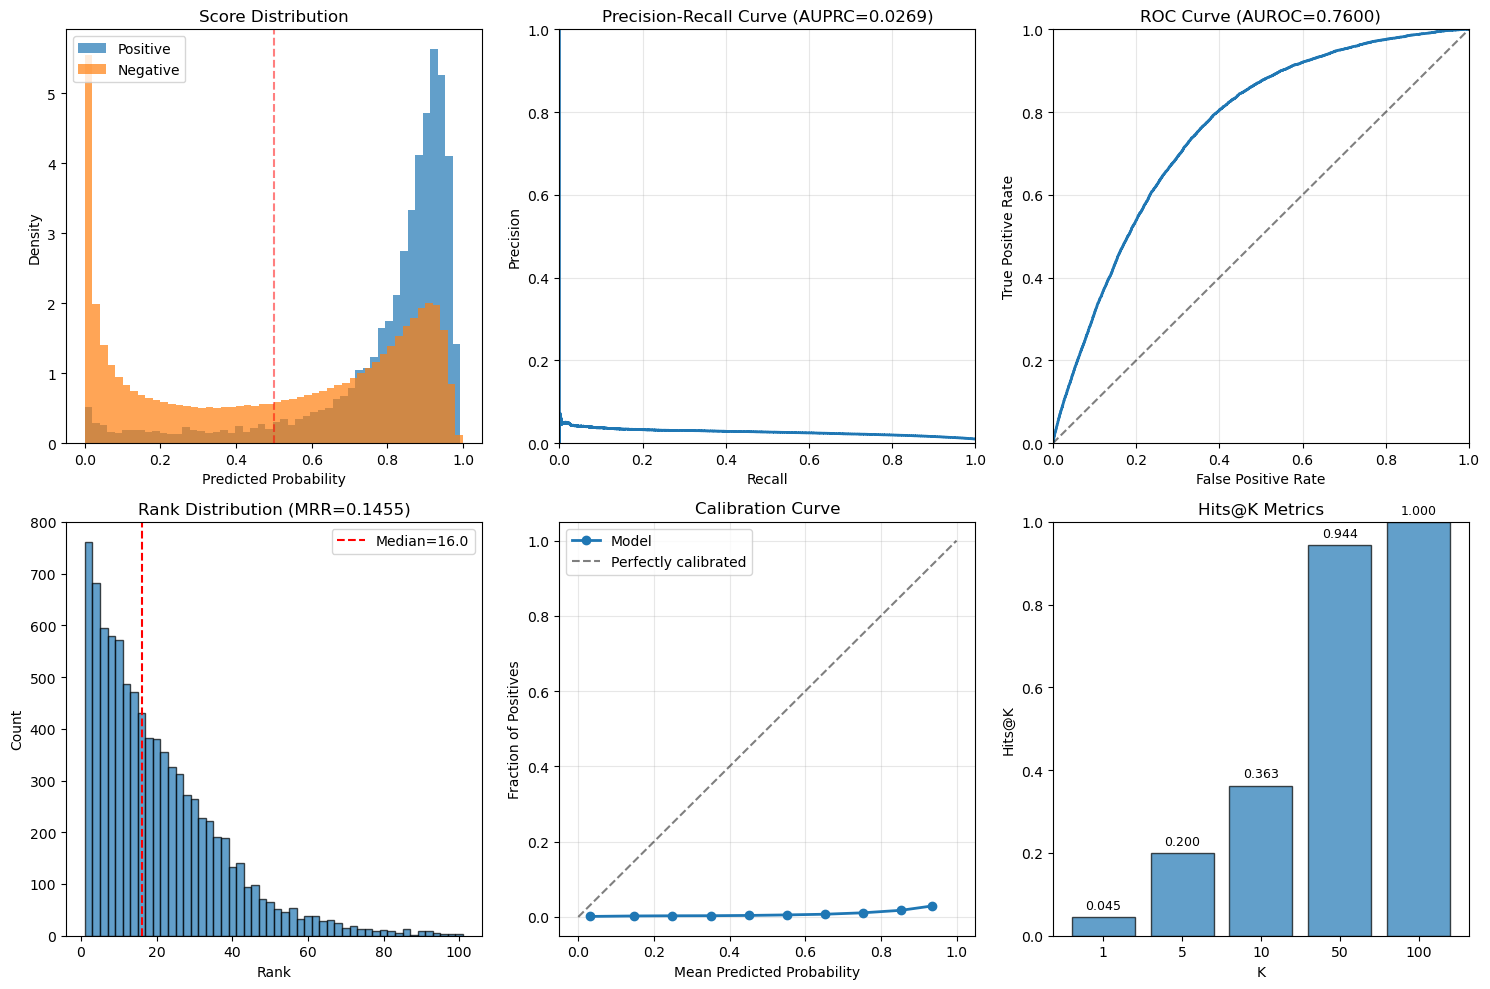

In [43]:
# Visualize results
fig = plot_evaluation_results(eval_results)
plt.show()

# Optionally save
# fig.savefig('./evaluation_results.png', dpi=150, bbox_inches='tight')

In [44]:
# Per-entity evaluation
disease_metrics, chemical_metrics = per_entity_evaluation(
    model=eval_model,
    data=data,
    test_pos=arts.split.test_pos,
    device=device,
    disease_df=dnodes,
    chemical_df=cnodes
)

print("\nTop 10 diseases by prediction confidence:")
print(disease_metrics.head(10))

print("\nBottom 10 diseases by prediction confidence:")
print(disease_metrics.tail(10))


Top 10 diseases by prediction confidence:
shape: (10, 9)
┌───────┬─────────────┬───────────┬──────────┬───┬──────────┬────────────┬────────────┬────────────┐
│ DS_ID ┆ n_test_edge ┆ mean_prob ┆ std_prob ┆ … ┆ max_prob ┆ pct_above_ ┆ DS_OMIM_ME ┆ DS_NAME    │
│ ---   ┆ s           ┆ ---       ┆ ---      ┆   ┆ ---      ┆ 0.5        ┆ SH_ID      ┆ ---        │
│ i64   ┆ ---         ┆ f64       ┆ f64      ┆   ┆ f64      ┆ ---        ┆ ---        ┆ str        │
│       ┆ i64         ┆           ┆          ┆   ┆          ┆ f64        ┆ str        ┆            │
╞═══════╪═════════════╪═══════════╪══════════╪═══╪══════════╪════════════╪════════════╪════════════╡
│ 1283  ┆ 1           ┆ 0.981612  ┆ 0.0      ┆ … ┆ 0.981612 ┆ 1.0        ┆ MESH:D0167 ┆ Death,     │
│       ┆             ┆           ┆          ┆   ┆          ┆            ┆ 57         ┆ Sudden,    │
│       ┆             ┆           ┆          ┆   ┆          ┆            ┆            ┆ Cardiac    │
│ 769   ┆ 1           ┆ 0.9711   

In [45]:
print("\nTop 10 chemicals by prediction confidence:")
print(chemical_metrics.head(10))

print("\nBottom 10 chemicals by prediction confidence:")
print(chemical_metrics.tail(10))


Top 10 chemicals by prediction confidence:
shape: (10, 9)
┌─────────┬────────────┬───────────┬──────────┬───┬──────────┬────────────┬────────────┬───────────┐
│ CHEM_ID ┆ n_test_edg ┆ mean_prob ┆ std_prob ┆ … ┆ max_prob ┆ pct_above_ ┆ CHEM_MESH_ ┆ CHEM_NAME │
│ ---     ┆ es         ┆ ---       ┆ ---      ┆   ┆ ---      ┆ 0.5        ┆ ID         ┆ ---       │
│ i64     ┆ ---        ┆ f64       ┆ f64      ┆   ┆ f64      ┆ ---        ┆ ---        ┆ str       │
│         ┆ i64        ┆           ┆          ┆   ┆          ┆ f64        ┆ str        ┆           │
╞═════════╪════════════╪═══════════╪══════════╪═══╪══════════╪════════════╪════════════╪═══════════╡
│ 5035    ┆ 1          ┆ 0.982396  ┆ 0.0      ┆ … ┆ 0.982396 ┆ 1.0        ┆ D007479    ┆ Iopamidol │
│ 5349    ┆ 9          ┆ 0.981238  ┆ 0.007927 ┆ … ┆ 0.991356 ┆ 1.0        ┆ D002998    ┆ Clonazepa │
│         ┆            ┆           ┆          ┆   ┆          ┆            ┆            ┆ m         │
│ 4398    ┆ 8          ┆ 0.97823

In [ ]:
# Save evaluation results
import json

# Filter out numpy arrays for JSON serialization
json_results = {k: v for k, v in eval_results.items() if not k.startswith('_')}

os.makedirs('./eval_results', exist_ok=True)

with open('./eval_results/metrics.json', 'w') as f:
    json.dump(json_results, f, indent=2)

disease_metrics.write_parquet('./eval_results/disease_metrics.parquet')
chemical_metrics.write_parquet('./eval_results/chemical_metrics.parquet')

print("Evaluation results saved to ./eval_results/")